In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm_notebook
np.set_printoptions(suppress=True)
from sklearn import preprocessing
from tqdm import tqdm
import decimal
from itertools import combinations
from random import shuffle
from time import sleep
tqdm.pandas()
from sklearn.preprocessing import LabelEncoder
import gc
import datetime
from sklearn.model_selection import train_test_split, KFold, GroupKFold
import os
from sklearn.metrics import roc_auc_score
plt.style.use('ggplot')
np.set_printoptions(suppress=True)
import random
import lightgbm as lgb

In [2]:
#Always seed the randomness of this universe
def seed_everything(seed=51):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [3]:
seed_everything(seed=51)

In [4]:
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)

In [5]:
train_dtypes = pd.read_csv('../input/train9_dtypes.csv')
test_dtypes = pd.read_csv('../input/test9_dtypes.csv')
train_dtypes.index = train_dtypes['TransactionID']
del train_dtypes['TransactionID']
test_dtypes.index = test_dtypes['TransactionID']
del test_dtypes['TransactionID']
train_dtypes = train_dtypes.iloc[:,0]
test_dtypes = test_dtypes.iloc[:,0]
print(type(train_dtypes),type(test_dtypes))
train_dtypes = train_dtypes.to_dict()
test_dtypes = test_dtypes.to_dict()
gc.collect()

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


21

In [6]:
%%time
train = pd.read_csv('../input/train_PI_1ekim.csv',dtype= train_dtypes)
print("train finished")

train finished
CPU times: user 22.4 s, sys: 1.14 s, total: 23.6 s
Wall time: 23.6 s


In [7]:
%%time
test = pd.read_csv('../input/test_PI_1ekim.csv',dtype= test_dtypes)
print("test finished")

test finished
CPU times: user 19.8 s, sys: 712 ms, total: 20.5 s
Wall time: 20.5 s


In [8]:
#sample_submission
sample_submission = pd.read_csv('../input/sample_submission.csv')
print(train.shape,test.shape,sample_submission.shape)

(590540, 359) (506691, 358) (506691, 2)


In [9]:
group_columns = [x for x in train.columns if 'group' in x]

In [10]:
print(group_columns)
print(len(group_columns))

['group_1_mean', 'group_1_median', 'group_1_min', 'group_1_max', 'group_1_sum', 'group_1_std', 'group_1_kurtosis', 'group_2_mean', 'group_2_median', 'group_2_min', 'group_2_max', 'group_2_sum', 'group_2_std', 'group_2_kurtosis', 'group_3_mean', 'group_3_median', 'group_3_min', 'group_3_max', 'group_3_sum', 'group_3_std', 'group_3_kurtosis', 'group_4_mean', 'group_4_median', 'group_4_min', 'group_4_max', 'group_4_sum', 'group_4_std', 'group_4_kurtosis', 'group_5_mean', 'group_5_median', 'group_5_min', 'group_5_max', 'group_5_sum', 'group_5_std', 'group_5_kurtosis', 'group_6_mean', 'group_6_median', 'group_6_min', 'group_6_max', 'group_6_sum', 'group_6_std', 'group_6_kurtosis', 'group_7_mean', 'group_7_median', 'group_7_min', 'group_7_max', 'group_7_sum', 'group_7_std', 'group_7_kurtosis', 'group_8_mean', 'group_8_median', 'group_8_min', 'group_8_max', 'group_8_sum', 'group_8_std', 'group_8_kurtosis', 'group_9_mean', 'group_9_median', 'group_9_min', 'group_9_max', 'group_9_sum', 'group_9

In [11]:
shared = ['C1', 'C10', 'C10_fq_enc', 'C11', 'C11_fq_enc', 'C12', 'C12_fq_enc', 'C13', 'C14', 'C14_fq_enc', 'C1_fq_enc', 'C2', 'C2_fq_enc', 'C3', 'C4', 'C4_fq_enc',
 'C6_fq_enc', 'C7', 'C8', 'C8_fq_enc', 'D13', 'DT_M', 'DeviceInfo', 'DeviceInfo_999999', 'DeviceInfo_fq_enc', 'DeviceType', 'DeviceType_mobile', 'M4', 'M5',
 'M6', 'P_emaildomain', 'Pemaildomain_DeviceInfo', 'Pemaildomain_mail.com', 'Pemaildomain_outlook.com', 'Pemaildomain_protonmail', 'ProductCD', 
 'ProductCD_DeviceInfo', 'ProductCD_card3', 'ProductCD_card5', 'ProductCD_dist2', 'R_emaildomain', 'R_emaildomain_bin', 'R_emaildomain_prefix', 
 'Remaildomain_DeviceInfo', 'Remaildomain_icloud.com', 'Remaildomain_lesscategory', 'Remaildomain_protonmail', 'V149', 'V152', 'V154', 'V156', 
 'V187', 'V189', 'V198', 'V201', 'V243', 'V245', 'V248', 'V249', 'V252', 'V256', 'V257', 'V258', 'V259', 'V261', 'V281', 'V33', 'V34', 'V44',
 'V45', 'V57', 'V58', 'V61', 'V62', 'V67', 'V79', 'V81', 'V82', 'V83', 'V86', 'V87', 'V94', 'card1_fraudulent', 'card2_fraudulent', 'card3_185.0', 
 'card3_DeviceInfo', 'card3_TransactionAmt_mean', 'card4_count_full', 'card5_TransactionAmt_mean', 'card5_TransactionAmt_std', 'card6', 'card6_count_full',
 'device_name_fq_enc', 'dist1_91.0', 'email_check', 'group_10_kurtosis', 'group_5_mean', 'group_5_median', 'group_6_kurtosis', 'id03subtractid04',
 'id03sumid04', 'id13_52.0', 'id14_999999', 'id14_999999.0', 'id19_321.0', 'id19_427.0', 'id20_127.0', 'id20_333.0', 'id20_417.0', 'id20_507.0',
 'id20_638.0', 'id31_firefox', 'id31_opera', 'id33_1280x720', 'id33_2208x1242', 'id_01', 'id_03', 'id_17', 'id_31', 'is_debit', 
 'uid2_TransactionAmt_mean', 'uid3', 'uid_TransactionAmt_mean']

In [12]:
only_gain = ['C13_fq_enc', 'C5', 'C7_fq_enc', 'C_nansum', 'DeviceInfo_Trident/7.0', 'TransactionAmt_decimal_0.0', 'V103', 'V138', 'V140',
             'V153', 'V16', 'V170', 'V172', 'V175', 'V180', 'V188', 'V190', 'V192', 'V194', 'V199', 'V205', 'V220', 'V225', 'V227',
             'V232', 'V237', 'V239', 'V244', 'V246', 'V251', 'V262', 'V266', 'V282', 'V283', 'V29', 'V294', 'V295', 'V296', 'V313', 
             'V315', 'V317', 'V322', 'V323', 'V324', 'V326', 'V331', 'V47', 'V48', 'V54', 'V55', 'V66', 'V69', 'V70', 'V76', 'V85',
             'V90', 'V91', 'V_nanmedian', 'addr2_fq_enc', 'card2_TransactionAmt_std', 'card3_TransactionAmt_std', 'card3_addr2',
             'card3_count_full', 'card3_fq_enc', 'dist1_86.0', 'group_15_max', 'group_15_mean', 'group_15_median', 'group_4_std',
             'group_5_std', 'group_6_sum', 'id09sumid10', 'id19_216.0', 'id33_firstframe', 'id_32']

In [13]:
only_split = ['C_nanstd', 'D14', 'D8', 'DT_D', 'DT_M_total', 'DT_W', 'DT_W_total', 'P_emaildomain_fq_enc', 'P_emaildomain_prefix',
              'ProductCD_addr1', 'R_emaildomain_fq_enc', 'TransactionAmt', 'TransactionAmt_check', 'TransactionAmt_decimal',
              'TransactionAmt_to_mean_card4', 'TransactionAmt_to_std_card4', 'V200', 'V215', 'V241', 'V253', 'V254', 'V255', 
              'V277', 'V278', 'V39', 'addr1', 'addr1_addr2', 'addr1_fq_enc', 'addr2', 'card1', 'card1_addr1', 'card1_count_full',
              'card1_fq_enc', 'card2', 'card2_TransactionAmt_mean', 'card2_fq_enc', 'card4', 'device_name', 'group_5_kurtosis', 
              'group_6_max', 'group_6_mean', 'group_7_max', 'group_9_std', 'id05subtractid06', 'id05sumid06', 'id09subtractid10',
              'id13_27.0', 'id13_999999', 'id18_15.0', 'id19_153.0', 'id19_266.0', 'id19_384.0', 'id20_325.0', 'id_06', 'id_13',
              'id_14', 'id_16', 'id_20', 'id_38', 'relative_hour', 'uid2', 'uid2_fq_enc', 'uid3_TransactionAmt_mean',
              'uid3_TransactionAmt_std', 'uid3_fq_enc', 'uid4', 'uid_DT_M', 'uid_DT_W', 'uid_fq_enc']

In [14]:
all_columns = shared + only_gain + only_split

In [15]:
print(all_columns)
print(len(all_columns))

['C1', 'C10', 'C10_fq_enc', 'C11', 'C11_fq_enc', 'C12', 'C12_fq_enc', 'C13', 'C14', 'C14_fq_enc', 'C1_fq_enc', 'C2', 'C2_fq_enc', 'C3', 'C4', 'C4_fq_enc', 'C6_fq_enc', 'C7', 'C8', 'C8_fq_enc', 'D13', 'DT_M', 'DeviceInfo', 'DeviceInfo_999999', 'DeviceInfo_fq_enc', 'DeviceType', 'DeviceType_mobile', 'M4', 'M5', 'M6', 'P_emaildomain', 'Pemaildomain_DeviceInfo', 'Pemaildomain_mail.com', 'Pemaildomain_outlook.com', 'Pemaildomain_protonmail', 'ProductCD', 'ProductCD_DeviceInfo', 'ProductCD_card3', 'ProductCD_card5', 'ProductCD_dist2', 'R_emaildomain', 'R_emaildomain_bin', 'R_emaildomain_prefix', 'Remaildomain_DeviceInfo', 'Remaildomain_icloud.com', 'Remaildomain_lesscategory', 'Remaildomain_protonmail', 'V149', 'V152', 'V154', 'V156', 'V187', 'V189', 'V198', 'V201', 'V243', 'V245', 'V248', 'V249', 'V252', 'V256', 'V257', 'V258', 'V259', 'V261', 'V281', 'V33', 'V34', 'V44', 'V45', 'V57', 'V58', 'V61', 'V62', 'V67', 'V79', 'V81', 'V82', 'V83', 'V86', 'V87', 'V94', 'card1_fraudulent', 'card2_fr

In [16]:
train = train[['isFraud','TransactionID'] + all_columns]
test = test[['TransactionID'] + all_columns]

In [17]:
print(train.shape,test.shape)

(590540, 269) (506691, 268)


In [18]:
merged_train = pd.read_csv('../input/merged_train.csv')
merged_test = pd.read_csv('../input/merged_test.csv')

In [22]:
importances = pd.read_csv('../importances/importances30.csv')

In [27]:
important_features = [x for x in list(importances['index']) if (len(x) >20) & ('_1' in x)]

In [29]:
important_features = ['card2_card3_card5_addr1is_1',
 'card2_card5_addr1_addr2is_1',
 'card1_card3_addr1_addr2is_1',
 'card1_card5_addr1_addr2is_1',
 'card1_card3_card5_addr1is_1',
 'card1_card2_card5_addr1is_1',
 'card1_card3_card5_addr2is_1',
 'card1_card2_card3_addr1is_1',
 'card1_card2_card3_addr2is_1',
 'card2_card3_card5_addr2is_1',
 'card2_card3_addr1_addr2is_1',
 'card1_card2_card3_card5is_1',
 'card1_card2_addr1_addr2is_1',
 'card3_card5_addr1_addr2is_1',
 'card1_card2_card5_addr2is_1']

In [30]:
print(len(important_features))

15


In [31]:
print(merged_train.shape,merged_test.shape)

(590540, 31) (506691, 31)


In [32]:
train = train.merge(merged_train,on = 'TransactionID', how = 'left' )
test = test.merge(merged_test,on = 'TransactionID', how = 'left' )
print(train.shape,test.shape)
gc.collect()

(590540, 299) (506691, 298)


14

# Training

In [33]:
train.head()

,isFraud,TransactionID,C1,C10,C10_fq_enc,C11,C11_fq_enc,C12,C12_fq_enc,C13,C14,C14_fq_enc,C1_fq_enc,C2,C2_fq_enc,C3,C4,C4_fq_enc,C6_fq_enc,C7,C8,C8_fq_enc,D13,DT_M,DeviceInfo,DeviceInfo_999999,DeviceInfo_fq_enc,DeviceType,DeviceType_mobile,M4,M5,M6,P_emaildomain,Pemaildomain_DeviceInfo,Pemaildomain_mail.com,Pemaildomain_outlook.com,Pemaildomain_protonmail,ProductCD,ProductCD_DeviceInfo,ProductCD_card3,ProductCD_card5,ProductCD_dist2,R_emaildomain,R_emaildomain_bin,R_emaildomain_prefix,Remaildomain_DeviceInfo,Remaildomain_icloud.com,Remaildomain_lesscategory,Remaildomain_protonmail,V149,V152,V154,V156,V187,V189,V198,V201,V243,V245,V248,V249,V252,V256,V257,V258,V259,V261,V281,V33,V34,V44,V45,V57,V58,V61,V62,V67,V79,V81,V82,V83,V86,V87,V94,card1_fraudulent,card2_fraudulent,card3_185.0,card3_DeviceInfo,card3_TransactionAmt_mean,card4_count_full,card5_TransactionAmt_mean,card5_TransactionAmt_std,card6,card6_count_full,device_name_fq_enc,dist1_91.0,email_check,group_10_kurtosis,group_5_mean,group_5_median,group_6_kurtosis,id03subtractid04,id03sumid04,id13_52.0,id14_999999,id14_999999.0,id19_321.0,id19_427.0,id20_127.0,id20_333.0,id20_417.0,id20_507.0,id20_638.0,id31_firefox,id31_opera,id33_1280x720,id33_2208x1242,id_01,id_03,id_17,id_31,is_debit,uid2_TransactionAmt_mean,uid3,uid_TransactionAmt_mean,C13_fq_enc,C5,C7_fq_enc,C_nansum,DeviceInfo_Trident/7.0,TransactionAmt_decimal_0.0,V103,V138,V140,V153,V16,V170,V172,V175,V180,V188,V190,V192,V194,V199,V205,V220,V225,V227,V232,V237,V239,V244,V246,V251,V262,V266,V282,V283,V29,V294,V295,V296,V313,V315,V317,V322,V323,V324,V326,V331,V47,V48,V54,V55,V66,V69,V70,V76,V85,V90,V91,V_nanmedian,addr2_fq_enc,card2_TransactionAmt_std,card3_TransactionAmt_std,card3_addr2,card3_count_full,card3_fq_enc,dist1_86.0,group_15_max,group_15_mean,group_15_median,group_4_std,group_5_std,group_6_sum,id09sumid10,id19_216.0,id33_firstframe,id_32,C_nanstd,D14,D8,DT_D,DT_M_total,DT_W,DT_W_total,P_emaildomain_fq_enc,P_emaildomain_prefix,ProductCD_addr1,R_emaildomain_fq_enc,TransactionAmt,TransactionAmt_check,TransactionAmt_decimal,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card4,V200,V215,V241,V253,V254,V255,V277,V278,V39,addr1,addr1_addr2,addr1_fq_enc,addr2,card1,card1_addr1,card1_count_full,card1_fq_enc,card2,card2_TransactionAmt_mean,card2_fq_enc,card4,device_name,group_5_kurtosis,group_6_max,group_6_mean,group_7_max,group_9_std,id05subtractid06,id05sumid06,id09subtractid10,id13_27.0,id13_999999,id18_15.0,id19_153.0,id19_266.0,id19_384.0,id20_325.0,id_06,id_13,id_14,id_16,id_20,id_38,relative_hour,uid2,uid2_fq_enc,uid3_TransactionAmt_mean,uid3_TransactionAmt_std,uid3_fq_enc,uid4,uid_DT_M,uid_DT_W,uid_fq_enc,card1_card2_card3_card5is_0,card1_card2_card3_card5is_1,card1_card2_card3_addr1is_0,card1_card2_card3_addr1is_1,card1_card2_card3_addr2is_0,card1_card2_card3_addr2is_1,card1_card2_card5_addr1is_0,card1_card2_card5_addr1is_1,card1_card2_card5_addr2is_0,card1_card2_card5_addr2is_1,card1_card2_addr1_addr2is_0,card1_card2_addr1_addr2is_1,card1_card3_card5_addr1is_0,card1_card3_card5_addr1is_1,card1_card3_card5_addr2is_0,card1_card3_card5_addr2is_1,card1_card3_addr1_addr2is_0,card1_card3_addr1_addr2is_1,card1_card5_addr1_addr2is_0,card1_card5_addr1_addr2is_1,card2_card3_card5_addr1is_0,card2_card3_card5_addr1is_1,card2_card3_card5_addr2is_0,card2_card3_card5_addr2is_1,card2_card3_addr1_addr2is_0,card2_card3_addr1_addr2is_1,card2_card5_addr1_addr2is_0,card2_card5_addr1_addr2is_1,card3_card5_addr1_addr2is_0,card3_card5_addr1_addr2is_1
0,0,2987000,1.0,0.0,824420,2.0,168780,0.0,856080,1.0,1.0,598520,586742,1.0,581696,0.0,0.0,823454,631237,0.0,0.0,816304,-999.0,12,2564,0,863508,2,0,2,0,1,12,19,0,0,0,4,283,37,81,64,12,6,12,31,0,0,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,0.0,0.0,-999.0,-999.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1,0,0,143,147.625,9524,185.250,999.000,1,267648,863508,0,0,NaN,0.4092,0.0,-1.720,NaN,Na

In [34]:
train.drop(['relative_hour'],axis=1,inplace=True)
test.drop(['relative_hour'],axis=1,inplace=True)
gc.collect()

7

In [35]:
train.drop(['TransactionID'],axis=1,inplace=True)
test.drop(['TransactionID'],axis=1,inplace=True)
gc.collect()

14

In [36]:
train.head()

,isFraud,C1,C10,C10_fq_enc,C11,C11_fq_enc,C12,C12_fq_enc,C13,C14,C14_fq_enc,C1_fq_enc,C2,C2_fq_enc,C3,C4,C4_fq_enc,C6_fq_enc,C7,C8,C8_fq_enc,D13,DT_M,DeviceInfo,DeviceInfo_999999,DeviceInfo_fq_enc,DeviceType,DeviceType_mobile,M4,M5,M6,P_emaildomain,Pemaildomain_DeviceInfo,Pemaildomain_mail.com,Pemaildomain_outlook.com,Pemaildomain_protonmail,ProductCD,ProductCD_DeviceInfo,ProductCD_card3,ProductCD_card5,ProductCD_dist2,R_emaildomain,R_emaildomain_bin,R_emaildomain_prefix,Remaildomain_DeviceInfo,Remaildomain_icloud.com,Remaildomain_lesscategory,Remaildomain_protonmail,V149,V152,V154,V156,V187,V189,V198,V201,V243,V245,V248,V249,V252,V256,V257,V258,V259,V261,V281,V33,V34,V44,V45,V57,V58,V61,V62,V67,V79,V81,V82,V83,V86,V87,V94,card1_fraudulent,card2_fraudulent,card3_185.0,card3_DeviceInfo,card3_TransactionAmt_mean,card4_count_full,card5_TransactionAmt_mean,card5_TransactionAmt_std,card6,card6_count_full,device_name_fq_enc,dist1_91.0,email_check,group_10_kurtosis,group_5_mean,group_5_median,group_6_kurtosis,id03subtractid04,id03sumid04,id13_52.0,id14_999999,id14_999999.0,id19_321.0,id19_427.0,id20_127.0,id20_333.0,id20_417.0,id20_507.0,id20_638.0,id31_firefox,id31_opera,id33_1280x720,id33_2208x1242,id_01,id_03,id_17,id_31,is_debit,uid2_TransactionAmt_mean,uid3,uid_TransactionAmt_mean,C13_fq_enc,C5,C7_fq_enc,C_nansum,DeviceInfo_Trident/7.0,TransactionAmt_decimal_0.0,V103,V138,V140,V153,V16,V170,V172,V175,V180,V188,V190,V192,V194,V199,V205,V220,V225,V227,V232,V237,V239,V244,V246,V251,V262,V266,V282,V283,V29,V294,V295,V296,V313,V315,V317,V322,V323,V324,V326,V331,V47,V48,V54,V55,V66,V69,V70,V76,V85,V90,V91,V_nanmedian,addr2_fq_enc,card2_TransactionAmt_std,card3_TransactionAmt_std,card3_addr2,card3_count_full,card3_fq_enc,dist1_86.0,group_15_max,group_15_mean,group_15_median,group_4_std,group_5_std,group_6_sum,id09sumid10,id19_216.0,id33_firstframe,id_32,C_nanstd,D14,D8,DT_D,DT_M_total,DT_W,DT_W_total,P_emaildomain_fq_enc,P_emaildomain_prefix,ProductCD_addr1,R_emaildomain_fq_enc,TransactionAmt,TransactionAmt_check,TransactionAmt_decimal,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card4,V200,V215,V241,V253,V254,V255,V277,V278,V39,addr1,addr1_addr2,addr1_fq_enc,addr2,card1,card1_addr1,card1_count_full,card1_fq_enc,card2,card2_TransactionAmt_mean,card2_fq_enc,card4,device_name,group_5_kurtosis,group_6_max,group_6_mean,group_7_max,group_9_std,id05subtractid06,id05sumid06,id09subtractid10,id13_27.0,id13_999999,id18_15.0,id19_153.0,id19_266.0,id19_384.0,id20_325.0,id_06,id_13,id_14,id_16,id_20,id_38,uid2,uid2_fq_enc,uid3_TransactionAmt_mean,uid3_TransactionAmt_std,uid3_fq_enc,uid4,uid_DT_M,uid_DT_W,uid_fq_enc,card1_card2_card3_card5is_0,card1_card2_card3_card5is_1,card1_card2_card3_addr1is_0,card1_card2_card3_addr1is_1,card1_card2_card3_addr2is_0,card1_card2_card3_addr2is_1,card1_card2_card5_addr1is_0,card1_card2_card5_addr1is_1,card1_card2_card5_addr2is_0,card1_card2_card5_addr2is_1,card1_card2_addr1_addr2is_0,card1_card2_addr1_addr2is_1,card1_card3_card5_addr1is_0,card1_card3_card5_addr1is_1,card1_card3_card5_addr2is_0,card1_card3_card5_addr2is_1,card1_card3_addr1_addr2is_0,card1_card3_addr1_addr2is_1,card1_card5_addr1_addr2is_0,card1_card5_addr1_addr2is_1,card2_card3_card5_addr1is_0,card2_card3_card5_addr1is_1,card2_card3_card5_addr2is_0,card2_card3_card5_addr2is_1,card2_card3_addr1_addr2is_0,card2_card3_addr1_addr2is_1,card2_card5_addr1_addr2is_0,card2_card5_addr1_addr2is_1,card3_card5_addr1_addr2is_0,card3_card5_addr1_addr2is_1
0,0,1.0,0.0,824420,2.0,168780,0.0,856080,1.0,1.0,598520,586742,1.0,581696,0.0,0.0,823454,631237,0.0,0.0,816304,-999.0,12,2564,0,863508,2,0,2,0,1,12,19,0,0,0,4,283,37,81,64,12,6,12,31,0,0,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,0.0,0.0,-999.0,-999.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1,0,0,143,147.625,9524,185.250,999.000,1,267648,863508,0,0,NaN,0.4092,0.0,-1.720,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-999.0

In [37]:
y = train['isFraud']
del train['isFraud']

In [38]:
print(train.shape,test.shape)

(590540, 296) (506691, 296)


In [39]:
train = train[list(train.columns)[:-30] + important_features]
test = test[list(train.columns)[:-30] + important_features]
print(train.shape,test.shape)

(590540, 281) (506691, 266)


In [40]:
########################### Model params
lgb_params = {'num_leaves': 546,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.1797454081646243,
          'bagging_fraction': 0.2181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3299927210061127,
          'reg_lambda': 0.3885237330340494,
          'random_state': 42,
}

In [41]:
N = 5
kf = KFold(n_splits=N)

importance = pd.DataFrame(np.zeros((train.shape[1], N)), columns=['Fold_{}'.format(i) for i in range(1, N + 1)], index=train.columns)
scores = []
y_pred = np.zeros(test.shape[0])
oof = np.zeros(train.shape[0])

for fold, (trn_idx, val_idx) in enumerate(kf.split(train, y), 1):
    print('Fold {}'.format(fold))
          
    trn_data = lgb.Dataset(train.iloc[trn_idx, :].values, label=y.iloc[trn_idx].values)
    val_data = lgb.Dataset(train.iloc[val_idx, :].values, label=y.iloc[val_idx].values)   
    
    #params, dtrain, 1600, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=500
    clf = lgb.train(lgb_params, trn_data ,2000 ,valid_sets=[trn_data, val_data], verbose_eval=200,early_stopping_rounds=100)

    predictions = clf.predict(train.iloc[val_idx, :].values) 
    importance.iloc[:, fold - 1] = clf.feature_importance()
    oof[val_idx] = predictions

    score = roc_auc_score(y.iloc[val_idx].values, predictions)
    scores.append(score)
    print('Fold {} ROC AUC Score {}\n'.format(fold, score))

    y_pred += clf.predict(test) / N
    
    del trn_data, val_data, predictions
    gc.collect()
    
print('Average ROC AUC Score {} [STD:{}]'.format(np.mean(scores), np.std(scores)))

Fold 1
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.973386	valid_1's auc: 0.903143
[400]	training's auc: 0.989554	valid_1's auc: 0.916072
[600]	training's auc: 0.99612	valid_1's auc: 0.923626
[800]	training's auc: 0.998655	valid_1's auc: 0.927233
[1000]	training's auc: 0.999539	valid_1's auc: 0.928912
[1200]	training's auc: 0.99985	valid_1's auc: 0.929355
[1400]	training's auc: 0.999952	valid_1's auc: 0.929973
Early stopping, best iteration is:
[1402]	training's auc: 0.999953	valid_1's auc: 0.92999
Fold 1 ROC AUC Score 0.9299904745718898

Fold 2
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.972082	valid_1's auc: 0.927326
[400]	training's auc: 0.989647	valid_1's auc: 0.937245
[600]	training's auc: 0.996486	valid_1's auc: 0.94217
[800]	training's auc: 0.998934	valid_1's auc: 0.943949
[1000]	training's auc: 0.999683	valid_1's auc: 0.944423
[1200]	training's auc: 0.99991	valid_1's auc: 0.944434
Early stoppin

In [42]:
print(roc_auc_score(y,oof))

0.9405580708227811


In [43]:
importance['avg'] = importance.mean(axis=1)

In [44]:
importance = importance.sort_values(by='avg',ascending=False)

In [45]:
importance = importance.reset_index(drop=False)

In [46]:
importance

,index,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5,avg
0,uid3_TransactionAmt_mean,21525,19029,12587,17544,16083,17353.6
1,uid3_fq_enc,21067,17631,11978,15863,15823,16472.4
2,DT_D,19375,15762,14264,14728,16000,16025.8
3,uid_DT_W,18319,15734,10230,13761,14440,14496.8
4,uid3,16722,14560,10600,13512,15227,14124.2
5,uid_DT_M,17710,15567,9728,13966,12651,13924.4
6,card1_addr1,15885,14012,10112,13350,14435,13558.8
7,uid3_TransactionAmt_std,15866,13514,10456,12230,12673,12947.8
8,TransactionAmt_to_mean_card4,15996,13571,10676,11922,12360,12905.0
9,card1,14623,13250,10494,12298,13005,12734.0


In [47]:
importance.to_csv('../importances/importances33.csv',index=False)

In [48]:
sample_submission.head()

,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5
2,3663551,0.5
3,3663552,0.5
4,3663553,0.5


In [49]:
sample_submission['isFraud'] = y_pred

In [50]:
sample_submission.head()

,TransactionID,isFraud
0,3663549,0.000779
1,3663550,0.002367
2,3663551,0.002548
3,3663552,0.002981
4,3663553,0.001452


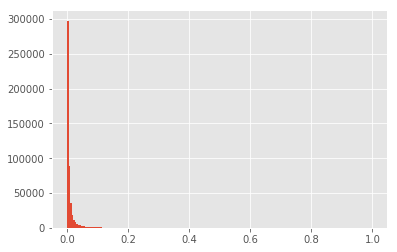

In [51]:
plt.hist(sample_submission['isFraud'],bins=200)
plt.show()

In [52]:
sample_submission.to_csv('../predictions/pred33.csv',index=False)

In [53]:
!kaggle competitions submit -c ieee-fraud-detection -f ../predictions/pred33.csv -m "pred33"

100%|███████████████████████████████████████| 14.1M/14.1M [00:33<00:00, 442kB/s]
Successfully submitted to IEEE-CIS Fraud Detection